In [1059]:
import MetaTrader5 as mt
import pandas as pd
import numpy as np
from datetime import datetime
import time
import schedule
import warnings
warnings.filterwarnings("ignore")



In [1074]:
def job():
    mt.initialize()
    login =160259737
    password= 'Abiodun95'
    server= 'ForexTimeFXTM-Demo01'
    mt.login(login, password, server)
    print(mt.account_info())
    
    
    

def job1(currency_pair='EURUSD', lot=0.06):
    #currency_pair="EURUSD"
    eurusd_rates = mt.copy_rates_from(currency_pair, mt.TIMEFRAME_M5, datetime(2030,4,30),100)
    Df = pd.DataFrame(eurusd_rates)
    # convert time in seconds into the datetime format
    Df['time']=pd.to_datetime(Df['time'], unit='s')
    
    
    #d, parse_dates = ['Quarter'],date_parser=parse)
    #df.head()
    
    
    #df= Df[:-7]
    df=Df.iloc[:-1,:]
    df=df.set_index('time')
    print(Df.tail())
    print(df.tail())
    
    
    from statsmodels.tsa.stattools import kpss    
    tstest = kpss(df['close'], 'ct')
    tstest
    
    
    
     
    
    
    #X= df['close'].values
    #print(X)
    
    from statsmodels.tsa.ar_model import AutoReg
    from statsmodels.tsa.stattools import adfuller
    dftest= adfuller(df['close'], autolag = 'AIC')
    
    print('1.ADF:', dftest[0])
    print('2.P-Value:', dftest[1])
    print('3.Num of Lags:', dftest[2])
    print('4.Num of Obser. used for ADFregr and Critical val calculation:', dftest[4])
    print('5.Critical Values:')
    for key, val in dftest[4].items():
        print("\t", key,":", val)
    
    
    from matplotlib import pyplot
    from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
    pacf = plot_pacf(df['close'], lags=25)
    #acf = plot_acf(df['close'], lag=12)
    pyplot.show()
    
    
    
    train = df['close'][:len(df['close'])-7]
    test = df['close'][len(df['close'])-7:]
    model = AutoReg(train, lags=8).fit()
    print(model.summary())
    
    pred=model.predict(start=len(train), end=len(df['close'])-1, dynamic=False)
    pred=round(pred, 5)
    from matplotlib import pyplot
    pyplot.plot(pred)
    pyplot.plot(test, color='red')
    
    
    print(pred)
    
    
    from math import sqrt
    from sklearn.metrics import mean_squared_error
    rmse = sqrt(mean_squared_error(test, pred))
    print('rmse',rmse)
    print('mse', mean_squared_error(test, pred))
    
    
    pred_future= model.predict(start= len(df['close'])+1, end=len(df['close'])+1, dynamic=False)
    pred_future=round(pred_future, 5)
    print("\n These are the next preds:")
    print(pred_future)
    print("\n Number of predictions Made: \t", len(pred_future))
    
    
    
    x = mt.symbol_info_tick(currency_pair).bid
    x= float(x)
    y =  mt.symbol_info_tick(currency_pair).ask
    y = float(y)
    print("\n Bid and Ask:\n",x,y)
    
      
    
    positions = mt.positions_total()
    balance = mt.account_info().balance
    #lot= 0.06
    #lot= round((balance*0.02)/100,2)
    symbol = currency_pair
    diff_for_long= (pred_future-x)
    diff_for_short= (pred_future-y)
    print("\n diff_for_long: \n", diff_for_long)
    print("\n diff_for_short: \n", diff_for_short)
    
    if dftest[1] < 0.5:
        print('\n P-Value: The Timeseries is Stationary \n')
    else:
        print('\n P-Value: The Timeseries is NOT STATIONARY \n')
        
    
    
    
    if (positions==0) and (pred_future.item() > x) and (diff_for_long.item() >= 0.0003) and (test.iloc[-1] > pred.iloc[-1]):
        point = mt.symbol_info(symbol).point
        price = mt.symbol_info_tick(symbol).ask        
        deviation = 20
        request_to_BUY = {
            "action": mt.TRADE_ACTION_DEAL,
            "symbol": symbol,
            "volume": lot,
            "type": mt.ORDER_TYPE_BUY,
            "price": price,
            "deviation": deviation,
            "sl": 0.0000,
            "tp":price + 30 * point,
            "magic": 2,
            "comment": "python script",
            "type_time": mt.ORDER_TIME_GTC,
            "type_filling": mt.ORDER_FILLING_FOK
        }
        # send a trading request
        result_buy = mt.order_send(request_to_BUY)
        
        print('\n buy \n')
    
    
    if (positions==0) and (pred_future.item() < y) and (diff_for_short.item() <= -0.0003) and (test.iloc[-1] < pred.iloc[-1]):
        
        
        point = mt.symbol_info(symbol).point
        price = mt.symbol_info_tick(symbol).bid        
        deviation = 20
        request_to_SELL = {
            "action": mt.TRADE_ACTION_DEAL,
            "symbol": symbol,
            "volume": lot,
            "type": mt.ORDER_TYPE_SELL,
            "price": price,
            "deviation": deviation,
            "sl": 0.0000,
            "tp": price - 30 * point,
            "magic": 2,
            "comment": "python script",
            "type_time": mt.ORDER_TIME_GTC,
            "type_filling": mt.ORDER_FILLING_FOK
        }
        # send a trading request
        result_sell = mt.order_send(request_to_SELL)
        
        print('\n sell \n')
        
        
        
        
        
        
def job3(currency_pair='EURUSD', lot=0.06):
    #lot= 0.06
    
    symbol = currency_pair
    if mt.account_info().profit <= -1:
        
    
        request_SELL_to_Close_Long_position = {
            "action": mt.TRADE_ACTION_DEAL,
            "symbol": symbol,
            "volume": lot,
            "type": mt.ORDER_TYPE_SELL,
            "position": result_buy.order,
            "price": mt.symbol_info_tick(symbol).ask,
            "deviation": deviation,
            "magic": 2,
            "comment": "python script",
            "type_time": mt.ORDER_TIME_GTC,
            "type_filling": mt.ORDER_FILLING_FOK
            }
        # send a trading request
        close_buy = mt.order_send(request_SELL_to_Close_Long_position)

        print("\n Long_Position_closed \n")
            
    if mt.account_info().profit <= -1:
        
        request_BUY_to_Close_Short_position = {
            "action": mt.TRADE_ACTION_DEAL,
            "symbol": symbol,
            "volume": lot,
            "type": mt.ORDER_TYPE_BUY,
            "position": result_sell.order,
            "price": mt.symbol_info_tick(symbol).bid,
            "deviation": deviation,
            "magic": 2,
            "comment": "python script",
            "type_time": mt.ORDER_TIME_GTC,
            "type_filling": mt.ORDER_FILLING_FOK
            }
        # send a trading request
        close_buy = mt.order_send(request_BUY_to_Close_Short_position)

        print("\n Short_Position_closed \n")      
    

In [1075]:
job()

AccountInfo(login=160259737, trade_mode=0, leverage=100, limit_orders=0, margin_so_mode=0, trade_allowed=True, trade_expert=True, margin_mode=2, currency_digits=2, fifo_close=False, balance=180.84, credit=0.0, profit=0.0, equity=180.84, margin=0.0, margin_free=180.84, margin_level=0.0, margin_so_call=80.0, margin_so_so=50.0, margin_initial=0.0, margin_maintenance=0.0, assets=0.0, liabilities=0.0, commission_blocked=0.0, name='Babatunde Abiodun Christian', server='ForexTimeFXTM-Demo01', currency='USD', company='FXTM')


                  time     open     high      low    close  tick_volume  \
95 2022-08-10 03:00:00  1.02078  1.02086  1.02040  1.02042          460   
96 2022-08-10 03:05:00  1.02045  1.02057  1.02042  1.02046          180   
97 2022-08-10 03:10:00  1.02047  1.02064  1.02036  1.02052          164   
98 2022-08-10 03:15:00  1.02052  1.02064  1.02043  1.02064          158   
99 2022-08-10 03:20:00  1.02063  1.02063  1.02042  1.02043          105   

    spread  real_volume  
95       1            0  
96       0            0  
97       0            0  
98       0            0  
99       0            0  
                        open     high      low    close  tick_volume  spread  \
time                                                                           
2022-08-10 02:55:00  1.02078  1.02084  1.02071  1.02078          122       1   
2022-08-10 03:00:00  1.02078  1.02086  1.02040  1.02042          460       1   
2022-08-10 03:05:00  1.02045  1.02057  1.02042  1.02046          180     

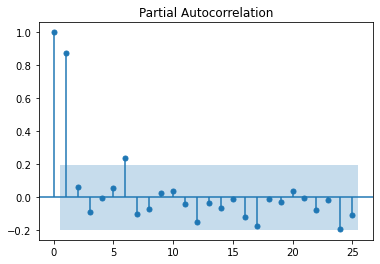

                            AutoReg Model Results                             
Dep. Variable:                  close   No. Observations:                   92
Model:                     AutoReg(8)   Log Likelihood                 620.873
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Wed, 10 Aug 2022   AIC                            -17.382
Time:                        01:24:10   BIC                            -17.093
Sample:                    08-09-2022   HQIC                           -17.266
                         - 08-10-2022                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0990      0.046      2.171      0.030       0.010       0.188
close.L1       0.9986      0.110      9.050      0.000       0.782       1.215
close.L2      -0.1278      0.155     -0.824      0.4

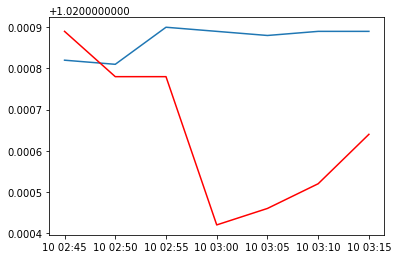

In [1076]:
job1()

In [1073]:
job3()

In [941]:


request_to_SELL = {
            "action": mt.TRADE_ACTION_DEAL,
            "symbol": symbol,
            "volume": lot,
            "type": mt.ORDER_TYPE_SELL,
            "price": price,
            "deviation": deviation,
            "sl": 0.0000
            ,
            "tp":0.0000,
            "magic": 2,
            "comment": "python script open(N_Network)",
            "type_time": mt.ORDER_TIME_GTC,
            "type_filling": mt.ORDER_FILLING_FOK
        }
        # send a trading request
result_sell = mt.order_send(request_to_SELL)


In [719]:
request_SELL_to_Close_Long_position = {
    "action": mt.TRADE_ACTION_DEAL,
    "symbol": symbol,
    "volume": lot,
    "type": mt.ORDER_TYPE_SELL,
    "position": result_buy.order,
    "price": price,
    "deviation": deviation,
    "magic": 2,
    "comment": "python script",
    "type_time": mt.ORDER_TIME_GTC,
    "type_filling": mt.ORDER_FILLING_FOK
}
        # send a trading request
close_buy = mt.order_send(request_SELL_to_Close_Long_position)


request_BUY_to_Close_Short_position = {
    "action": mt.TRADE_ACTION_DEAL,
    "symbol": symbol,
    "volume": lot,
    "type": mt.ORDER_TYPE_BUY,
    "position": result_sell.order,
    "price": price,
    "deviation": deviation,
    "magic": 2,
    "comment": "python script",
    "type_time": mt.ORDER_TIME_GTC,
    "type_filling": mt.ORDER_FILLING_FOK
}
        # send a trading request
close_buy = mt.order_send(request_BUY_to_Close_Short_position)



NameError: name 'result_sell' is not defined

In [1066]:
result_buy.order

2273019664

In [1065]:
d= mt.positions_get(group="*USD*")
df=pd.DataFrame(list(d).columns=d[0]._asdict().keys()) 

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (Temp/ipykernel_4020/2836713956.py, line 2)